# Conesa & Krueger (1999)
### John Ryan
This code was originally created for the solution to a problem set for Dean Corbae's computational economics course in Fall 2023. This was originally written in Julia, but is now translated to Python.

## Model

Each period a mass of workers is born, with constant population growth rate $n$ per period. Agents live for $N$ periods (adult years), with no stochastic mortality. Initial assets for each agent is $a_1 = 0$. Until age $j = J^R$, agents supply labor $\ell \in [0,1]$ to a representative firm. At age $J^R$, agents retire ($\ell = 0$) and earn pension benefits / social security $b$, which is financed by a linear labor income tax  with constant rate $\theta$. We assume the government keeps a balanced budget. Agents get period utility 

$$ u(c) - v(\ell) = \frac{c^{1-\sigma}}{1-\sigma} - \psi \frac{\ell^{1+\gamma}}{1+\gamma} $$

with a constant discount factor of $\beta$. Workers have productivity $e(z, j) = z*\eta_j$, where $\eta_j$ is a deterministic age-efficiency profile, and $z$ is a Markov process with an initial ergodic distribution at birth. There is a representative firm with production technology

$$ Y = K^\alpha L^{1-\alpha} $$

where $\alpha \in (0, 1)$ and labor depreciates at constant rate $\delta$. Labor and capital markets are assumed to be perfectly competitive. To solve the model computationally, we assume $z$ follows a 2 state Markov chain and take the following benchmark parameterization:

| Parameter | Value | Description |
| --- | --- | --- |
| $n$ | .011 | population growth rate |
| $N$ | 65 | length of adult life |
| $J^R$ | 46 | age of retirement |
| $\theta$ | .11 | income tax rate |
| $\gamma$ | 2.5 | inverse Frisch elasticity of labor supply |
| $\psi$ | 2.0 | labor disutility level
| $\sigma$ | 2 | coefficient of relative risk aversion for consumption|
| $\beta$ | .97 | discount factor | 
| $\alpha$ | .36 | capital share |
| $\delta$ | .06 | capital depreciation |
| $z_H $ | 1.0 | high productivity value |
| $z_L$ | .25 | low productivity value |
| $\pi_H$ | .2037 | high productivity initial probability |
| $\pi_{HH}$ | .9261 | high productivity persistence probability |
| $\pi_{LL}$ | .9811 | low productivity persistence probability |
| $\eta_j$ | plotted below | age efficiency profile |



---

## Part 1

First we solve the dynamic programming problem for a retiree and worker. For now we assume the values $r=.05, w=1.05, b=.2$, but these will be solved for later. We start at the end of life, $j=N$, and iterate backwards. We normalize the value of death to $V_{N+1} = 0$.

A retiree has the following dynamic programming problem:


$$ V_j(a) = \max_{a' \ge 0} u((1 + r)a + b − a') + βV_{j+1}(a'),$$

Where they supply no labor, and we have used the budget constraint $c + a' = (1+r)a + b$. We exploit the fact that there is no bequest motive, so at the age of death, agents consume all of their wealth, $a'=0$. 

A worker has the following dynamic programming problem:


$$ V_j(a) = \max_{a' \ge 0, 0 \le \ell \le 1} u(w(1 - \theta)e(z, \eta_j)\ell + (1+r)a - a') - v(\ell) + \beta \mathbb{E}[V_{j+1}(a',z')|(a,z,j)]$$

We have plugged in the budget constraint $c + a' = w(1-\theta)e(z, j)\ell + (1+r)a$ into the utility function. We can use the first order condition of the household to solve for labor: 

$$ \frac{v'(\ell)}{u'(c)} =  w(1 - \theta)e(z, \eta_j)$$

So that we can simplify the problem to the household just choosing $a'$ in 
each period as a function of their state $(j, a, z)$ and 
the next period's value function $V_{j+1}$. The policy function is $a_j '(a, z)$. 
The household's labor supply is then $\ell_j(a,z)$.


Text(0.5, 1.0, 'Age-efficiency profile')

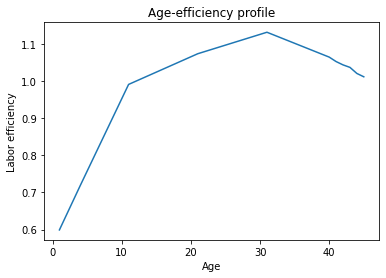

In [1]:
import numpy as np
# include OLGModel class from OLG_functions.py
from OLG_functions_fast_Frisch import OLGModel, V_induction, steady_dist, market_clearing
import matplotlib.pyplot as plt
import time

# read in ef.txt as a numpy array
ef = np.loadtxt('ef.txt', delimiter=',')

# plot ef across [1, .., len(ef)]
x = np.arange(1, len(ef)+1)
plt.plot(x, ef)
plt.xlabel('Age')
plt.ylabel('Labor efficiency')
plt.title('Age-efficiency profile')

First, we will use grid search to solve for the household value functions and policy functions.

In [2]:
OLG = OLGModel(a_min=.000001, a_max=25.0, na=300, eta=ef, gamma=2.5, z_grid=np.array([1.0, .25]))

# solve HH problem
start = time.time()
V_r, g_r, c_r, V_w, g_w, c_w, l_w = V_induction(OLG, r=.032, w=1.382, b=.181)
end = time.time()
print('Time to solve HH problem: ', end - start)

Time to solve HH problem:  10.025576829910278


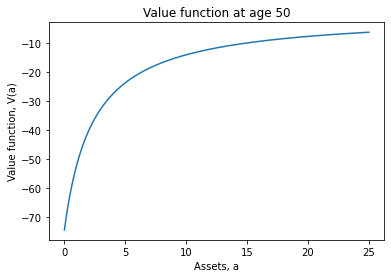

In [3]:
plt.plot(OLG.a_grid, V_r[4, :])
plt.xlabel('Assets, a')
plt.ylabel('Value function, V(a)')
plt.title('Value function at age 50')
plt.show()

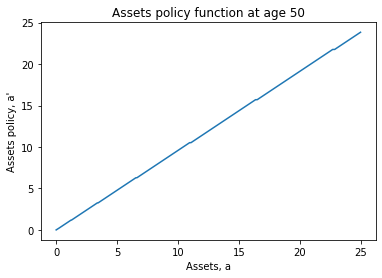

In [4]:
plt.plot(OLG.a_grid, g_r[4, :])
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
plt.title('Assets policy function at age 50')
plt.show()

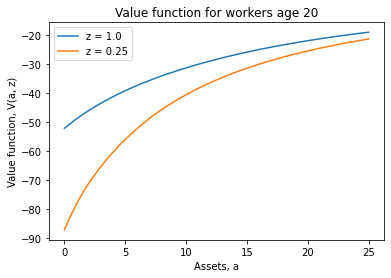

In [5]:

# Plot V_w for each value of z
j = 20
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, V_w[j-1, :, i], label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('Assets, a')
plt.ylabel('Value function, V(a, z)')
plt.title('Value function for workers age 20')
plt.legend()
plt.show()

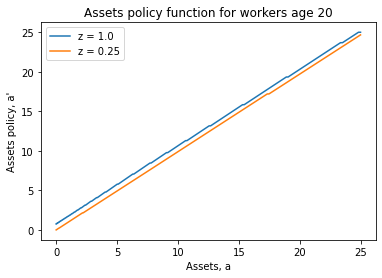

In [6]:
# Plot g_w for each value of z
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, g_w[j-1, :, i], label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
plt.title('Assets policy function for workers age 20')
plt.legend()
plt.show()

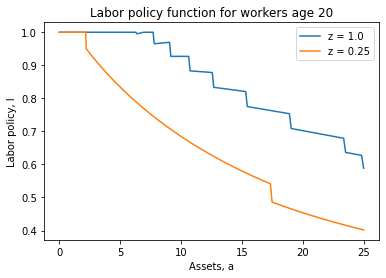

In [7]:
# Plot l_w for each value of z
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, l_w[j-1, :, i], label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l')
plt.title('Labor policy function for workers age 20')
plt.legend()

## Endogenous Grid Method

Here we will use an implementation of the endogenous grid method (Carroll, 2005) to speed up the code as well as improve its accuracy.

We will have a slightly different algorithm for retired agents than workers. For a retired agent, their problem is just the cake eating problem as they just consume out of their wealth. 

We will utilize the Euler equation for the household. From the retired household DP problem, we have the final value function in closed form:

$$ V_N(a) = u((1+r)a)$$

Thus, we also have

$$V_N'(a) = (1+r)u'((1+r)a) = (1+r) u'((1+r)a)$$

Next, we have the envelope condition for a household in period t:

$$ V'_{j}(a_j) = (1+r) u'(c_j)$$

and finally, the household FOC:

$$ u'(c_j) = \beta V'_{j+1}(a_{j+1}) $$

This implies an Euler equation which holds for each period of retirement:

$$ u'(c_j) = \beta (1+r) u'(c_{j+1}) $$

This could also be derived using the sequence problem of the household upon retirement. 

The algorithm for a retired worker is as follows:

1. Initialize a grid of final asset values $A_N $
2. From the household's budget constraint find $c_N = (1+r) a_N$ (the household consumes all of their wealth at end of life)
3. Use the household's Euler equation to solve for the implied preceding consumption path: $u'(c_{j-1}) = \beta (1+r) u'(c_j)$
4. Use budget constraints in each priod to find the level of assets in each time period: $a_j = \frac{c_j + a_{j+1}}{1+r} $.
5. Interpolate the consumption policy function $c_j(a)$ at each age $j$
6. Evaluate the policy functions on an exogenous grid.
7. If you still want value functions, they can be solved for brute force by finding the present discounted utility from the consumption path associated with a level of assets.


For a worker, the problem is slightly more complicated because of the larger state space and the labor choice. The state space for a worker is assets $a$ and a realization of productivity $z$. Recall the dynamic programming problem of the household is:

$$ 
\begin{align*}
V_j(a, z) = \max_{a' \ge 0, 0 \le \ell \le 1, c} \quad &u(c) - v(\ell) + \beta \mathbb{E}[V_{j+1}(a',z')|(a,z,j)]\\
 &s.t. \quad c + a' = w * z * \eta_j * (1-\theta) * \ell + (1+r)a

\end{align*}
$$

This implies 2 optimality conditions, an intertemporal Euler equation and an intratemporal consumption - labor optimality condition. The Euler equation for a worker is:

$$ u'(c_j) = \beta (1+r) \mathbb{E}_j[u'(c_{j+1})| z] $$

The intratemporal optimality condition is

$$ v'(\ell) \leq w *u'(c)$$

Which holds with equality if $\ell$ is interior


In [8]:
from OLG_EGM import OLGModel as OLG_EGM
from OLG_EGM import market_clearing as market_clearing_egm
from OLG_EGM import HH_egm, steady_dist_egm, stochastic_simulation

In [10]:
# time the HH_egm function
og = OLG_EGM(eta=ef, na=300, gamma=2.5, a_min=.000001, a_max=25.0, z_grid=np.array([1.0, .25]), N=65)

start = time.time()
a_policy_w, a_policy_r, c_policy_w, c_policy_r, l_policy = HH_egm(og, r=.032, w=1.38, b=.181)
end = time.time()
print(f'Time elapsed: {end-start}')

Time elapsed: 0.0023107528686523438


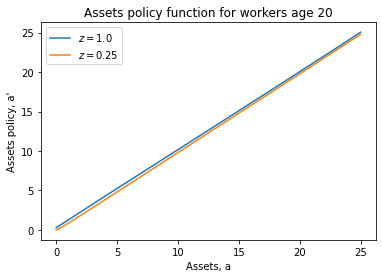

In [11]:
j = 1 # specify the value of j
plt.plot(og.a_grid, a_policy_w[j-1, 0, :])
plt.plot(og.a_grid, a_policy_w[j-1, 1, :])
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
# set title
plt.title('Assets policy function for workers age 20')
plt.legend([f'$z={og.z_grid[0]}$', f'$z={og.z_grid[1]}$'])
plt.show()

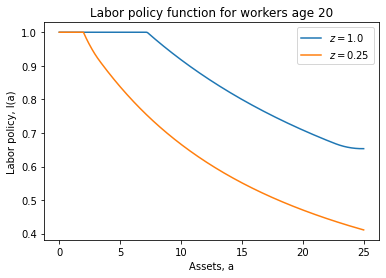

In [12]:
plt.plot(og.a_grid, l_policy[19, 0, :])
plt.plot(og.a_grid, l_policy[19, 1, :])
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l(a)')
# set title
plt.title('Labor policy function for workers age 20')
plt.legend([f'$z={og.z_grid[0]}$', f'$z={og.z_grid[1]}$'])
plt.show()

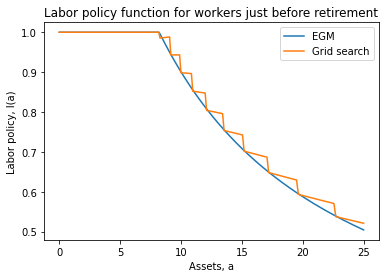

In [13]:
plt.plot(og.a_grid, l_policy[-1, 0, :], label='EGM')
plt.plot(OLG.a_grid, l_w[-1, :, 0], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l(a)')
# set title
plt.title('Labor policy function for workers just before retirement')
plt.legend()

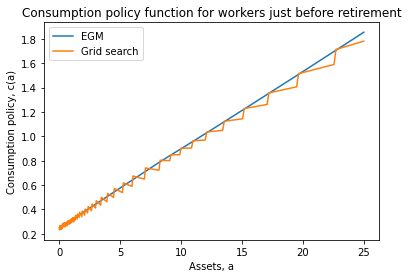

In [14]:
# compare consumption policy functions between grid search and egm
plt.plot(og.a_grid, c_policy_w[-1, 0, :], label='EGM')
plt.plot(OLG.a_grid, c_w[-1, :, 0], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Consumption policy, c(a)')
# set title
plt.title('Consumption policy function for workers just before retirement')
plt.legend()

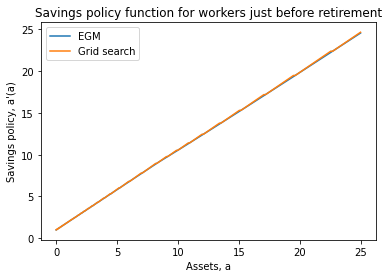

In [15]:
# compare savings policy functions
plt.plot(og.a_grid, a_policy_w[-1, 0, :], label='EGM')
plt.plot(OLG.a_grid, g_w[-1, :, 0], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Savings policy, a\'(a)')
# set title
plt.title('Savings policy function for workers just before retirement')
plt.legend()

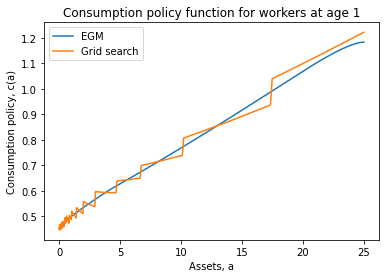

In [16]:
# compare consumption policy functions at age 1
j = 0
plt.plot(og.a_grid, c_policy_w[j, 0, :], label='EGM')
plt.plot(OLG.a_grid, c_w[j, :, 0], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Consumption policy, c(a)')
# set title
plt.title('Consumption policy function for workers at age 1')
plt.legend()


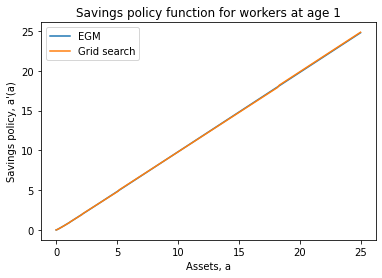

In [17]:
# compare savings policy functions at age 1
plt.plot(og.a_grid, a_policy_w[0, 1, :], label='EGM')
plt.plot(OLG.a_grid, g_w[0, :, 1], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Savings policy, a\'(a)')
# set title
plt.title('Savings policy function for workers at age 1')
plt.legend()

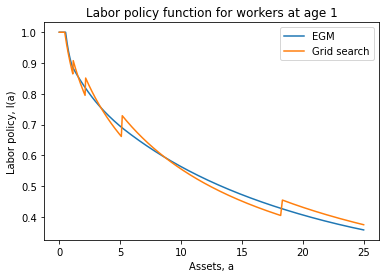

In [18]:
# compare labor policy functions at age 1
plt.plot(og.a_grid, l_policy[0, 1, :], label='EGM')
plt.plot(OLG.a_grid, l_w[0, :, 1], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l(a)')
# set title
plt.title('Labor policy function for workers at age 1')
plt.legend()

Text(0.5, 1.0, 'Assets policy function for retirees')

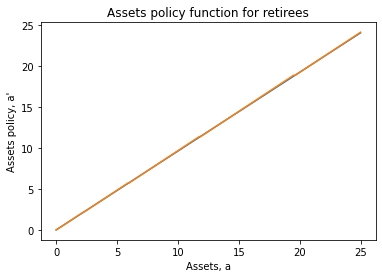

In [19]:
# compare assets policy functions in retirement
j = 0
plt.plot(og.a_grid, a_policy_r[j, :], label='EGM')
plt.plot(OLG.a_grid, g_r[j, :], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
# set title
plt.title('Assets policy function for retirees')

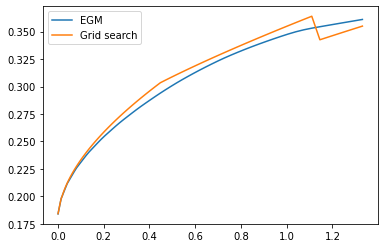

In [25]:
# plot the consumption policy function at age 0
plt.plot(og.a_grid[:70], c_policy_w[0, 1, :70], label='EGM')
plt.plot(OLG.a_grid[:70], c_w[0, :70, 1], label='Grid search')
plt.legend()

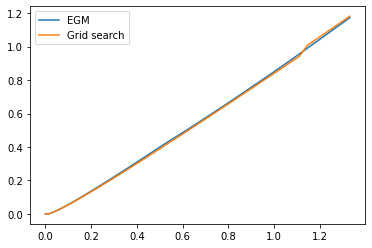

In [26]:
# plot the consumption policy function at age 0
plt.plot(og.a_grid[:70], a_policy_w[0, 1, :70], label='EGM')
plt.plot(OLG.a_grid[:70], g_w[0, :70, 1], label='Grid search')
plt.legend()

## Part 2 

### Grid search distribution of agents

Here we solve for the stationary distribution of agents across age, productivity and wealth given the choices of households, $h_j(z, a)$. The benefit of grid search is that it guarantees by construction that the policy functions for agents will lie on the assets grid, so the discretization of the steady state distribution follows directly from solving the household problem (and the birth / death rate). First we find the relative size of each cohort of age $j$ (denoted $\mu_j$) with 

$$ \mu_{j+1} = \frac{\mu_j}{1+n} $$ 

for each $j = 1, 2, ..., N-1$.

Then, we normalize so that $\sum_j \mu_j = 1$. Then we get the initial distribution from the intial ergodic distrubution of productivity by $h_1(z_H, 0) = \mu_1 \pi_H$, $h_1(z_L, 0) = \mu_1 \pi_L$. After obtaining the initial distribution from the population growth / death rates and the ergodic distribution of productivity shocks, we can iterate forward with policy functions. We exploit the grid structure of the policy functions, where both the state and the policy function lie on the grid. That is, $a, g(a, z) \in A = \{a_1, a_2, ..., a_K\}$. We use the following equations to iterate forward with policy functions:

$$ \begin{align*}
\text{workers: } \quad h_{j+1}(a', z') &= \sum_{a_k} \sum_{z \in \{z_H, z_L\}} \bold{1}\{a' = g_j(a_k, z)\} \Pi(z, z') h_j(a_k, z) \\

\text{retirees: } \quad h_{j+1}(a') &= \sum_{a_k} \bold{1}\{a' = g_j(a_k)\} h_j(a_k)
\end{align*}
$$

Note that since retired workers are not characterized by their productivity, the distribution of retired workers is just over age and assets. We also must make sure that the distributions are weighted properly across age according to $\sum_{a_k, z} h_j(a_k, z) = \mu_j$.

If the initial distribution is degenerate (no assets at birth), then there will be a "fanning out" of the distribution across the lifetime from the Markov process. For example, if agents start with no assets and there are two points in the Markov process, then each of the two possible agents will have two different choices of savings, and so there will be two possible asset values in the next period. Then those two points fan into 4 from different realizations of the productivity shock, and so forth. 



In [28]:
start = time.time()
h_w, h_r = steady_dist(OLG, g_w, g_r)
end = time.time()
print('Time to compute steady state distribution: ', end - start)

Time to compute steady state distribution:  0.014704227447509766


In [29]:
# initial distribution

h_w[0, 0, :]

array([0.00435517, 0.01702514])

In [30]:
# proportion of workers
np.sum(h_w)

0.7639686707684437

In [31]:
# proportion of retirees
np.sum(h_r)

0.23603132923155679

Text(0.5, 1.0, 'Distribution of agents by assets')

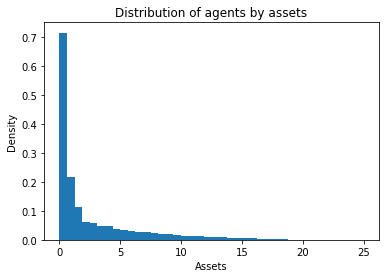

In [32]:
h_w_collapsed = np.sum(h_w, axis=(0, 2))
h_r_collapsed = np.sum(h_r, axis=0)
h_collapsed = h_w_collapsed + h_r_collapsed

# histogram of the distribution of agents by assets
plt.hist(OLG.a_grid, weights=h_collapsed, bins=40, density=True)
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title('Distribution of agents by assets')

### EGM steady state distribution

Unfortunately, the endogenous grid method does not share the convenience of grid search for steady state distribution estimation resulting from the already discretized policy functions. Instead, policy functions are continuous and it is unlikely that the policy function will fall exactly on the grid. Thus, when the policy function falls between to grid points, we will follow Young (2010) in splitting the probability across grid points according to their distance. This requries a slightly different process for points that lie outside the grid than for points that lie between grid points. Let the assets grid be $A = \{a_1, a_2, ..., a_K\}$. 

The intial distribution is obtained the same way as the grid search method. However, we iterate forward with different equations as follows:

Workers:
$$ \begin{align*}
\text{Grid min: } \quad h_{j+1}(a_1', z') &= \sum_{a_k} \sum_z \left(\bold{1}\{g_j(a_k, z) \leq a_1' \} + \bold{1}\{ a_1' < g_j(a_k, z) < a_2'\} \frac{a_2' - g_j(a_k, z)}{a_2' - a_1'}\right) \Pi(z, z') h_j(a_k) \\

\text{Interior point: } \quad h_{j+1}(a_\kappa', z') &= \sum_{a_k} \sum_z \left(\bold{1}\{a_{\kappa -1}'  < g_j(a_k, z) \leq a_\kappa' \}\frac{g_j(a_k, z) - a_{\kappa - 1}'}{a_\kappa' - a_{\kappa - 1}'} + \bold{1}\{ a_\kappa' < g_j(a_k, z) < a_{\kappa + 1}'\} \frac{a_{\kappa + 1}' - g_j(a_k, z)}{a_{\kappa + 1}' - a_\kappa'}\right) \Pi(z, z') h_j(a_k)\\

\text{Grid max: } \quad h_{j+1}(a_K', z') &= \sum_{a_k} \sum_z \left(\bold{1}\{ a_{K-1} < g_j(a_k, z) < a_K\} \frac{g_j(a_k, z) - a_{K-1}'}{a_K' - a_{K-1}'} + \bold{1}\{g_j(a_k, z) \geq a_K' \}\right) \Pi(z, z') h_j(a_k)
\end{align*}
$$

Retirees:
$$ \begin{align*}
\text{Grid min: } \quad h_{j+1}(a_1') &= \sum_{a_k} \left(\bold{1}\{g_j(a_k) \leq a_1' \} + \bold{1}\{ a_1' < g_j(a_k) < a_2'\} \frac{a_2' - g_j(a_k)}{a_2' - a_1'}\right) h_j(a_k) \\

\text{Interior point: } \quad h_{j+1}(a_\kappa') &= \sum_{a_k} \left(\bold{1}\{a_{\kappa -1}'  < g_j(a_k) \leq a_\kappa' \}\frac{g_j(a_k) - a_{\kappa - 1}'}{a_\kappa' - a_{\kappa - 1}'} + \bold{1}\{ a_\kappa' < g_j(a_k) < a_{\kappa + 1}'\} \frac{a_{\kappa + 1}' - g_j(a_k)}{a_{\kappa + 1}' - a_\kappa'}\right) h_j(a_k)\\

\text{Grid max: } \quad h_{j+1}(a_K') &= \sum_{a_k} \left(\bold{1}\{ a_{K-1} < g_j(a_k) < a_K\} \frac{g_j(a_k) - a_{K-1}'}{a_K' - a_{K-1}'} + \bold{1}\{g_j(a_k) \geq a_K' \}\right) h_j(a_k)
\end{align*}
$$



In [34]:
start = time.time()
h_w_egm, h_r_egm = steady_dist_egm(og, a_policy_w, a_policy_r)
end = time.time()
print('Time to compute steady state distribution: ', end - start)

Time to compute steady state distribution:  0.0021071434020996094


Text(0.5, 1.0, 'Distribution of agents by assets')

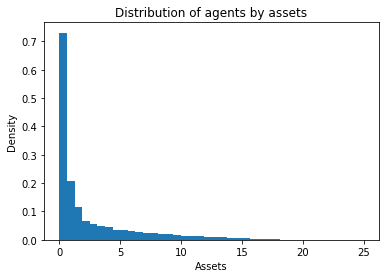

In [35]:
h_w_collapsed_egm = np.sum(h_w_egm, axis=(0, 2))
h_r_collapsed_egm = np.sum(h_r_egm, axis=0)
h_collapsed_egm = h_w_collapsed_egm + h_r_collapsed_egm

plt.hist(og.a_grid, weights=h_collapsed_egm, bins=40, density=True)
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title('Distribution of agents by assets')


### Stochastic simulation with EGM

The last two methods for estimating the distribution of agents exploited the asset grid and used policy functions to numerically approximate the distribution of agents. However, a more intuitive and realistic method for estimating the distribution of agents is to do so with stochastic simulation. Here is a sketch of the algorithm:

1. Simulate $M$ (large, say 10,000) draws from the Markov process across the lifetime, with zero assets at birth. Each draw is a vector length $J_r -1$ that represents the productivity shocks that a household faces throughout their lifetime.
2. Use the household asset policy functions to get the household decisions at each time period. Keep track of the asset holdings at each time period.
3. We should have a panel data set of $M$ households and their age across the $N$ periods of their lifetime, with productivity (while working) and asset holdings at each age. 
4. Bin the data within each age and productivity group according to the asset grid, $A = \{a_1, a_2, ..., a_K\}$. Weight each age group $j$ according to $\mu_j$.
5. Should have an approximate density function $h_j(a, z)$.

Computationally, it makes more sense to have a separate distribution for working and retired agents, as they have different state spaces and retired households are simpler. We can collapse this later to see the population distribution of assets across all age groups. 

In [31]:
start = time.time()
h_w_sim, h_r_sim = stochastic_simulation(og, a_policy_w, a_policy_r, M=50_000)
end = time.time()
print('Time to simulate: ', end - start)

Time to simulate:  1.4582209587097168


Text(0.5, 1.0, 'Distribution of agents by assets')

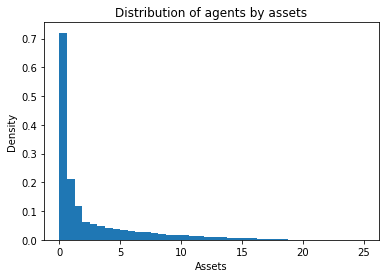

In [32]:
h_w_sim_collapsed = np.sum(h_w_sim, axis=(0, 2))
h_r_sim_collapsed = np.sum(h_r_sim, axis=0)
h_sim_collapsed = h_w_sim_collapsed + h_r_sim_collapsed

plt.hist(og.a_grid, weights=h_sim_collapsed, bins=40, density=True)
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title('Distribution of agents by assets')

---

## Part 3

Here we solve for a steady state in the benchmark model (described above). The algorithm is as follows:

1. Make initial guess for aggregates $K_0$, $L_0$
2. Solve for implied wage $w_0$ and interest rate $r_0$ using firm first order conditions
3. Use government budget constraint to solve for retirement benefits $b = \theta w_0 L_0 / \sum_{j=J^R}^N \mu_j$
4. Solve the household problem for value and policy functions given prices and retirement benefits
5. Find the implied distribution of wealth
6. Solve for the implied aggregate values $K_{new}$, $L_{new}$
7. Iterate aggregates in the direction of the new values, $K_1 = \rho K_{new} + (1-\rho) K_0$, $L_1 = \rho L_{new} + (1-\rho) L_0$ for $\rho \in (0, 1)$
8. Take new values as the initial guess and iterate until $\max\{|K_{new} - K_0|, |L_{new} - L_0|\} < \varepsilon$

In [38]:
# grid search
start = time.time()
eqbm = market_clearing(OLG, rho=.5, tol=.000001, K0=2.47, L0=.29)
end = time.time()
print('Time to solve for equilibrium: ', end - start)

print('K, L, r, w, b:')
print(eqbm)

K = <object type:float64>, L = <object type:float64>
Converged in 12 iterations
Time to solve for equilibrium:  92.14219617843628
K, L, r, w, b:
(2.505772717642878, 0.2904601491880535, 0.030647340362236333, 1.3902340012162087, 0.18206696153931481)


In [39]:
# EGM market clearing

start = time.time()
eqbm_egm = market_clearing_egm(og, rho=.5, tol=.000001, K0=2.46, L0=.29)
end = time.time()
print('Time to solve for equilibrium: ', end - start)

print('K, L, r, w, b:')
print(eqbm_egm)

Converged in 10 iterations
Time to solve for equilibrium:  0.041278839111328125
K, L, r, w, b:
(2.4489717292510607, 0.28987405482743533, 0.03186857009272766, 1.3798081870357723, 0.1864023399427115)


In [38]:
from OLG_EGM import K_L

def market_clearing_stochastic(OLG, tol=0.0001, max_iter=200, rho=.2, K0=3.32, L0=0.34, M=10000):
    # solve for the steady state using initial guess of capital and labor

    K, L = K0, L0
    n = 0
    # need initial retired share, will actually be very close to this value
    mu_r = np.sum(OLG.mu[OLG.J_r - 1:])
    error = 100 * tol
    while error > tol:
        r = OLG.alpha * (L / K) ** (1 - OLG.alpha) - OLG.delta
        w = (1 - OLG.alpha) * (K / L) ** OLG.alpha
        b = OLG.theta * w * L / mu_r
        a_w, a_r, _, _, l_w = HH_egm(OLG, r, w, b)
        h_w, h_r = stochastic_simulation(OLG, a_w, a_r, M)
        K_new, L_new = K_L(OLG, h_w, h_r, l_w)
        K = (1-rho) * K + rho * K_new
        L = (1-rho) * L + rho * L_new
        # print(f"K = {K}, L = {L}")
        error = max(abs(K_new - K), abs(L_new - L))
        n += 1
        if n > max_iter:
            print("No convergence")
            print(f"K = {K}, L = {L}")
            break

    if n < max_iter:
        print(f"Converged in {n} iterations")
        return K, L, r, w, b

In [8]:
# EGM stochastic market clearing

start = time.time()
eqbm_egm = market_clearing_stochastic(og, rho=.50, tol=.00005, K0=2.46, L0=.29, M=1_000_000)
end = time.time()
print('Time to solve for equilibrium: ', end - start)

print('K, L, r, w, b:')
print(eqbm_egm)

NameError: name 'market_clearing_stochastic' is not defined